In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import re
from fastcore.xtras import Path

import matplotlib.pyplot as plt

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaborLayerLogSigma_, GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2024-01-12 13:56:14.904561: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-12 13:56:15.018291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 13:56:17.732651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
config = {
    "BATCH_SIZE": 16,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
    "GABOR_KERNEL_SIZE": 31,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 16,
    "INIT_JH": True,
    "A_GDNSPATIOFREQORIENT": True,
}
config = ConfigDict(config)
config

A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 16
CS_KERNEL_SIZE: 21
EPOCHS: 10
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

In [3]:
# path_imgs = Path("/lustre/ific.uv.es/ml/uv075/Databases/Salicon/images/")
path_imgs = Path("/media/disk/databases/BBDD_video_image/Salicon/images/")
path_imgs_train = [str(p) for p in path_imgs.joinpath("train").glob("*.jpg")]
path_imgs_val = [str(p) for p in path_imgs.joinpath("val").glob("*.jpg")]
path_labels_train = [re.sub(r"(images)|(jpg)", lambda x: {'images': 'maps', 'jpg': 'png'}[x.group(0)], p) for p in path_imgs_train]
path_labels_val = [re.sub(r"(images)|(jpg)", lambda x: {'images': 'maps', 'jpg': 'png'}[x.group(0)], p) for p in path_imgs_val]
len(path_imgs_train), len(path_labels_train), len(path_imgs_val), len(path_labels_val)

(10000, 10000, 5000, 5000)

In [4]:
def preprocess(path_img,
               path_label,
               ):
    img_ref = tf.io.read_file(path_img)
    img_dist = tf.io.read_file(path_label)

    img_ref = tf.image.decode_jpeg(img_ref, channels=3)
    img_dist = tf.image.decode_png(img_dist, channels=1)

    img_ref = tf.image.convert_image_dtype(img_ref, dtype=tf.float32)
    img_dist = tf.image.convert_image_dtype(img_dist, dtype=tf.float32)

    return img_ref, img_dist

In [5]:
dst_train = tf.data.Dataset.from_tensor_slices((path_imgs_train, path_labels_train))\
                           .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
dst_val = tf.data.Dataset.from_tensor_slices((path_imgs_val, path_labels_val))\
                         .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

In [6]:
dst_train_rdy = dst_train.shuffle(buffer_size=1000, seed=config.SEED, reshuffle_each_iteration=True)\
                         .batch(64, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)\
                         .prefetch(1)

dst_val_rdy = dst_val.batch(64, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)\
                     .prefetch(1)

In [7]:
a, b = next(iter(dst_train_rdy))
a.shape, b.shape

2024-01-12 13:56:27.329804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2024-01-12 13:56:27.330470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10000]
	 [[{{node Placeholder/_1}}]]


(TensorShape([64, 480, 640, 3]), TensorShape([64, 480, 640, 1]))

In [8]:
a, b = next(iter(dst_val_rdy))
a.shape, b.shape

2024-01-12 13:56:29.178442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [5000]
	 [[{{node Placeholder/_1}}]]
2024-01-12 13:56:29.178982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [5000]
	 [[{{node Placeholder/_1}}]]


(TensorShape([64, 480, 640, 3]), TensorShape([64, 480, 640, 1]))

In [9]:
wandb.init(project="PerceptNet_Saliency",
           name="V19_128GaborFree_A",
           job_type="training",
           config=config,
           mode="disabled",
           )
config = config
config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 16
CS_KERNEL_SIZE: 21
EPOCHS: 10
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
SEED: 42
USE_BIAS: false
ZERO_MEAN: true

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [10]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FG = FreqGaussianGamma()
        OG = OrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FG(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        outputs = OG(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        denom = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)

In [11]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        ## 1x1 Conv to reduce to a single channel
        outputs = nn.Conv(features=1, kernel_size=(1,1), strides=(1,1), padding="SAME")(outputs**2)
        outputs = nn.relu(outputs)
        
        ## Make the images back to the original size
        outputs = jax.image.resize(outputs, shape=(*inputs.shape[:-1], outputs.shape[-1]), method="bilinear")

        return outputs

## Define the metrics with `clu`

In [12]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [13]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [14]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [15]:
from functools import partial

In [16]:
@partial(jax.jit, static_argnums=2)
def train_step(state, batch, return_grads=False):
    """Train for a single step."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        loss = optax.l2_loss(img_pred, label)
        
        ## Calculate pearson correlation
        return loss.mean(), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    if return_grads: return state, grads
    else: return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [17]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        loss = optax.l2_loss(img_pred, label)
        
        ## Calculate pearson correlation
        return loss.mean()
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Train the model!

In [18]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
state = state.replace(params=clip_param(state.params, "A", a_min=0))

In [19]:
pred, _ = state.apply_fn({"params": state.params, **state.state}, jnp.ones(shape=(1,384,512,3)), train=True, mutable=list(state.state.keys()))

In [20]:
def check_trainable(path):
    # return ("A" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)
    if not config.A_GDNSPATIOFREQORIENT:
        return ("GDNSpatioFreqOrient_0" in path) and ("A" in path)
    return False

In [21]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))
trainable_tree

FrozenDict({
    GDN_0: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    Conv_0: {
        kernel: 'trainable',
    },
    GDN_1: {
        Conv_0: {
            kernel: 'trainable',
            bias: 'trainable',
        },
    },
    CenterSurroundLogSigmaK_0: {
        logsigma: 'trainable',
        K: 'trainable',
        A: 'trainable',
    },
    GDNGaussian_0: {
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
            bias: 'trainable',
        },
    },
    GaborLayerLogSigma__0: {
        freq: 'trainable',
        logsigmax2: 'trainable',
        logsigmay2: 'trainable',
        theta: 'trainable',
        sigma_theta: 'trainable',
    },
    GDNSpatioFreqOrient_0: {
        bias: 'trainable',
        GaussianLayerGamma_0: {
            gamma: 'trainable',
            A: 'trainable',
        },
        FreqGaussianGamma_0: {
            gamma: 'trainable',
        },
      

In [22]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [23]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [24]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [25]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
trainable_param_count = sum([w.size if t=="trainable" else 0 for w, t in zip(jax.tree_util.tree_leaves(state.params), jax.tree_util.tree_leaves(trainable_tree))])
param_count, trainable_param_count

(634, 634)

In [26]:
wandb.run.summary["total_parameters"] = param_count
wandb.run.summary["trainable_parameters"] = trainable_param_count

In [27]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Opponent color channel transformation
if config.INIT_JH:
    state.params["Conv_0"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
                                                  [115.8404,-63.3502,41.26816],
                                                  [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.01,1.01,
                                                            1.01,1.1,1.01,
                                                            1.01,1.01,1.1])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"])*0.1

## GDNSpatioFreqOrient
state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
state.params["GDNSpatioFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"])*(1/20)
state.params["GDNSpatioFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)


state = state.replace(params=freeze(state.params))

Before actually training the model we're going to set up the checkpointer to be able to save our trained models:

In [28]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [29]:
metrics_history = {
    "train_loss": [],
    "val_loss": [],
}

In [30]:
batch = next(iter(dst_train_rdy.as_numpy_iterator()))

In [31]:
from functools import partial

In [32]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [33]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [34]:
%%time
outputs = forward(state, batch[0])
outputs.shape

CPU times: user 31.2 s, sys: 1.18 s, total: 32.3 s
Wall time: 29.1 s


(64, 480, 640, 1)

In [35]:
%%time
outputs, _ = forward_intermediates(state, batch[0])
outputs.shape

CPU times: user 5.55 s, sys: 829 ms, total: 6.38 s
Wall time: 2.08 s


(64, 480, 640, 1)

In [36]:
%%time
s1, grads = train_step(state, batch, return_grads=True)

CPU times: user 3min, sys: 5.95 s, total: 3min 6s
Wall time: 2min 54s


In [37]:
# jax.config.update("jax_debug_nans", True)

In [38]:
def filter_extra(extra):
    def filter_intermediates(path, x):
        path = "/".join(path)
        if "Gabor" in path:
            return (x[0][0],)
        else: 
            return x
    extra = unfreeze(extra)
    extra["intermediates"] = flax.traverse_util.path_aware_map(filter_intermediates, extra["intermediates"])
    return freeze(extra)

In [39]:
%%time
for epoch in range(config.EPOCHS):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state, grads = train_step(state, batch, return_grads=True)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        state = state.replace(params=clip_param(state.params, "A", a_min=0))
        state = state.replace(params=clip_param(state.params, "K", a_min=1+1e-5))
        wandb.log({f"{k}_grad": wandb.Histogram(v) for k, v in flatten_params(grads).items()}, commit=False)
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation
    for batch in dst_val_rdy.as_numpy_iterator():
        state = compute_metrics(state=state, batch=batch)
        # break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())
    
    ## Obtain activations of last validation batch
    _, extra = forward_intermediates(state, batch[0])
    del _
    extra = filter_extra(extra) ## Needed because the Gabor layer has multiple outputs
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(extra["intermediates"]).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]} [Val] Loss: {metrics_history["val_loss"][-1]}')
    # print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]}')
    # break

Epoch 0 -> [Train] Loss: 0.013743908144533634 [Val] Loss: 0.013344037346541882
Epoch 1 -> [Train] Loss: 0.012045660056173801 [Val] Loss: 0.012772505171597004
Epoch 2 -> [Train] Loss: 0.011813205666840076 [Val] Loss: 0.012539719231426716
Epoch 3 -> [Train] Loss: 0.011736270971596241 [Val] Loss: 0.012469228357076645
Epoch 4 -> [Train] Loss: 0.011704832315444946 [Val] Loss: 0.012446887791156769
Epoch 5 -> [Train] Loss: 0.011683028191328049 [Val] Loss: 0.012412430718541145
Epoch 6 -> [Train] Loss: 0.011647100560367107 [Val] Loss: 0.012389889918267727
Epoch 7 -> [Train] Loss: 0.011631356552243233 [Val] Loss: 0.012368571013212204
Epoch 8 -> [Train] Loss: 0.011613359674811363 [Val] Loss: 0.012394275516271591
Epoch 9 -> [Train] Loss: 0.011606576852500439 [Val] Loss: 0.012334829196333885
CPU times: user 1h 5min 16s, sys: 7min 54s, total: 1h 13min 11s
Wall time: 29min 46s


In [40]:
pred = forward(state, batch[0])
pred.shape

(64, 480, 640, 1)

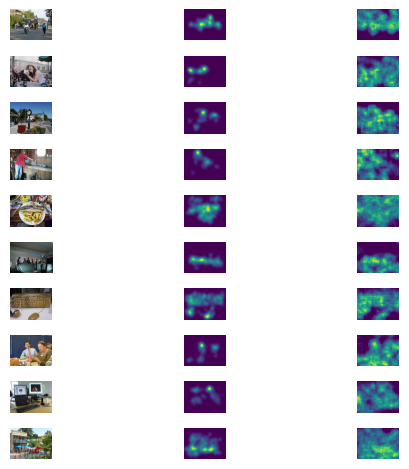

In [46]:
fig, axes = plt.subplots(10,3)
for i, axs in enumerate(axes):
    axs[0].imshow(batch[0][i])
    axs[1].imshow(batch[1][i])
    axs[2].imshow(pred[i])
for ax in axes.ravel(): ax.axis("off")
plt.tight_layout()
plt.show()

Save the final model as well in case we want to keep training from it or whatever:

In [42]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

ValueError: Destination /tmp/model-final already exists.

In [ ]:
wandb.finish()